# Data Understanding

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 198 kB 41.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=8188ea385777b81e867e107cb3c6cdbe8bbcd11379cccbbab0fb46dbec278758
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
from pyspark.sql.functions import when, col, isnan, count,  regexp_replace, udf
import numpy as np
import pyspark
import re
from math import sqrt
from geopy.geocoders import Nominatim
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
import pandas as pd
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, PCA
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, max as _max, min as _min
import folium
import pyspark.sql.functions as F
from pyspark.ml.clustering import KMeans, BisectingKMeansModel, KMeansSummary
from  pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from IPython.display import display
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.stat import Correlation
import missingno as msno

In [4]:
sc = pyspark.SparkContext()
sqlCtx = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

lettura del dataset come dataframe pyspark

In [6]:
# load the dataset
rain_path = 'drive/MyDrive/DDAM/Australia Rain/australia_rain_tomorrow_raw.csv'

# carico il dataframe
df = spark.read.load(rain_path, format="csv", sep=",", inferSchema="true", header="true")

In [7]:
df.show()

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|01/12/2008|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|  

In [8]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RISK_MM: double (nullable = true)
 |-- RainTomorrow: string (nullable = true)



lettura del dataset come rdd 

In [9]:
# rdd
rain_rdd = spark.sparkContext.textFile(rain_path)
rain_rdd.take(5)
print("Il numero di record present i nel dataset è = ", rain_rdd.count()-1)

Il numero di record present i nel dataset è =  142193


In [10]:
# take the first row and filter out the header
kdd_rain_header = rain_rdd.first()
rdd_rain_no_header = rain_rdd.filter(lambda l: l!=kdd_rain_header).map(lambda l : l.split(","))

In [11]:
print("Il numero di attributi è:", str(len(kdd_rain_header.split(","))))

Il numero di attributi è: 24


## Analisi Location

In [12]:
# Funzione per pulire nome Location
# alcuni nomi di città sono attaccati (senza spazi) e geocoders non riesce a trovare le coordinate

def location_replace(location):
  if location == 'PearceRAAF':
    return 'Pearce RAAF'
  else:
    result = re.findall('.[^A-Z]*', location)
    if len(result) > 1:
      location_new = result[0] + ' ' + result[1]
      return location_new
    else:
      return location

In [13]:
location_rdd = rdd_rain_no_header.map(lambda l: [location_replace(l[1])])
location_rdd.take(5)

[['Albury'], ['Albury'], ['Albury'], ['Albury'], ['Albury']]

In [14]:
# Sort in ordine decrescente delle città nell rdd

print("List of all the locations in the dataset")
cities_count_records = location_rdd.map(lambda l : (l[0], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda l: -l[1]).collect()
cities_count_records

List of all the locations in the dataset


[('Canberra', 3418),
 ('Sydney', 3337),
 ('Perth', 3193),
 ('Darwin', 3192),
 ('Hobart', 3188),
 ('Brisbane', 3161),
 ('Adelaide', 3090),
 ('Bendigo', 3034),
 ('Townsville', 3033),
 ('Alice Springs', 3031),
 ('Mount Gambier', 3030),
 ('Ballarat', 3028),
 ('Launceston', 3028),
 ('Albany', 3016),
 ('Albury', 3011),
 ('Melbourne Airport', 3009),
 ('Perth Airport', 3009),
 ('Mildura', 3007),
 ('Sydney Airport', 3005),
 ('Nuriootpa', 3002),
 ('Sale', 3000),
 ('Watsonia', 2999),
 ('Tuggeranong', 2998),
 ('Portland', 2996),
 ('Woomera', 2990),
 ('Cobar', 2988),
 ('Cairns', 2988),
 ('Wollongong', 2983),
 ('Gold Coast', 2980),
 ('Wagga Wagga', 2976),
 ('Norfolk Island', 2964),
 ('Penrith', 2964),
 ('Newcastle', 2955),
 ('Salmon Gums', 2955),
 ('Coffs Harbour', 2953),
 ('Witchcliffe', 2952),
 ('Richmond', 2951),
 ('Dartmoor', 2943),
 ('Norah Head', 2929),
 ('Badgerys Creek', 2928),
 ('Mount Ginini', 2907),
 ('Moree', 2854),
 ('Walpole', 2819),
 ('Pearce RAAF', 2762),
 ('Williamtown', 2553),
 ('M

In [15]:
# distinct location 
distinct_location = location_rdd.flatMap(lambda x: x).distinct()
print("The number of distinct locations is", distinct_location.count())

The number of distinct locations is 49


In [16]:
# Funzione per vedere dove sono le città nella mappa
def get_coordinate(city):
  country = 'Australia'
  geolocator = Nominatim(user_agent="Group_DDAM")
  location = geolocator.geocode(city+','+ country,timeout=50)
  #tuple_location = (city,location.latitude,location.longitude)
  return city, location.latitude, location.longitude

In [17]:
# facciamo il get_coordinate per ogni città distinta e trasformiamo il risultato in un dizionario

distinct_location_coord = distinct_location.map(get_coordinate)
distinct_location_coord.take(5)

# un esempio di come funziona il dizionario
#print("Latitude of Albury is", distinct_location_tuple['Albury'][0])
#print("Longitude of Albury is", distinct_location_tuple['Albury'][1])

[('Albury', -36.0804766, 146.9162795),
 ('Coffs Harbour', -30.2962407, 153.1135293),
 ('Norfolk Island', -29.0289575, 167.9587289126371),
 ('Sydney', -33.8548157, 151.2164539),
 ('Sydney Airport', -33.935309, 151.1655825)]

In [18]:
# Creiamo un piccolo dataframe per controllare e visualizzare le coordinate

columns = ["Address", "latitude", "longitude"]
location_coord_rdd_DF = distinct_location_coord.toDF(columns)
location_coord_rdd_DF.show(5)
location_coord_rdd_DF.printSchema()

+--------------+-----------+-----------------+
|       Address|   latitude|        longitude|
+--------------+-----------+-----------------+
|        Albury|-36.0804766|      146.9162795|
| Coffs Harbour|-30.2962407|      153.1135293|
|Norfolk Island|-29.0289575|167.9587289126371|
|        Sydney|-33.8548157|      151.2164539|
|Sydney Airport| -33.935309|      151.1655825|
+--------------+-----------+-----------------+
only showing top 5 rows

root
 |-- Address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [19]:
df_stats = location_coord_rdd_DF.select(
    _mean(col('latitude')).alias('meanLatitude'),
    _mean(col('longitude')).alias('meanLongitude'),
    _max(col('latitude')).alias('maxLatitude'),
    _min(col('latitude')).alias('minLatitude'),
    _max(col('longitude')).alias('maxLongitude'),
    _min(col('longitude')).alias('minLongitude')
).collect()

In [20]:
meanLatitude = df_stats[0]['meanLatitude']
meanLongitude = df_stats[0]['meanLongitude']
maxLatitude = df_stats[0]['maxLatitude']
minLatitude = df_stats[0]['minLatitude']
maxLongitude = df_stats[0]['maxLongitude']
minLongitude = df_stats[0]['minLongitude']

In [21]:
# Creiamo la mappa
map_australia = folium.Map(location=[meanLatitude, meanLongitude], zoom_start=4.8, control_scale=True)

# inseriamo le location all'interno della mappa
data_collect = location_coord_rdd_DF.collect()
for city in data_collect:
  folium.Marker([city[1], city[2]], popup= city[0]).add_to(map_australia) 

In [22]:
map_australia

 ## Queries

In [23]:
df.columns

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RISK_MM',
 'RainTomorrow']

In [24]:
# Creazione vista temporanea "temp"
df.createOrReplaceTempView("temp")

In [25]:
query = spark.sql("SELECT Location, count(*) as NrRecord FROM temp WHERE RainTomorrow='Yes' GROUP BY Location order by NrRecord DESC ")
query.show()

+-------------+--------+
|     Location|NrRecord|
+-------------+--------+
|     Portland|    1095|
|       Cairns|     950|
|      Walpole|     949|
|     Dartmoor|     922|
| MountGambier|     920|
|NorfolkIsland|     919|
|       Albany|     902|
|  Witchcliffe|     879|
| CoffsHarbour|     869|
|       Sydney|     865|
|       Darwin|     852|
|  MountGinini|     819|
|    NorahHead|     808|
|     Ballarat|     781|
|    GoldCoast|     775|
|SydneyAirport|     774|
|       Hobart|     761|
|     Watsonia|     738|
|    Newcastle|     731|
|   Wollongong|     713|
+-------------+--------+
only showing top 20 rows



In [26]:
query = spark.sql("SELECT Location, WindGustDir, count(*) as NrRecord FROM temp GROUP BY Location, WindGustDir order by NrRecord DESC ")
query.show()

+----------------+-----------+--------+
|        Location|WindGustDir|NrRecord|
+----------------+-----------+--------+
|          Albany|         NA|    3016|
|       Newcastle|         NA|    2955|
|          Sydney|         NA|    1036|
|      Townsville|        ENE|    1017|
|          Cairns|         SE|     965|
|MelbourneAirport|          N|     942|
|      Launceston|        NNW|     911|
|       Melbourne|          N|     739|
|           Perth|         SW|     727|
|      Launceston|         NW|     725|
|          Hobart|        NNW|     687|
|    AliceSprings|        ESE|     648|
|          Hobart|         NW|     629|
|            Sale|          W|     624|
|       GoldCoast|        SSE|     609|
|     Witchcliffe|        SSE|     606|
|        Canberra|         NW|     601|
|    PerthAirport|          E|     568|
|        Brisbane|          E|     560|
|      Townsville|         NE|     542|
+----------------+-----------+--------+
only showing top 20 rows



In [27]:
query = spark.sql("SELECT RISK_MM, RainToday, RainTomorrow FROM temp GROUP BY RISK_MM, RainToday, RainTomorrow order by RISK_MM DESC")
query.show(100)

+-------+---------+------------+
|RISK_MM|RainToday|RainTomorrow|
+-------+---------+------------+
|  371.0|      Yes|         Yes|
|  367.6|      Yes|         Yes|
|  278.4|      Yes|         Yes|
|  268.6|      Yes|         Yes|
|  247.2|      Yes|         Yes|
|  240.0|       NA|         Yes|
|  236.8|      Yes|         Yes|
|  225.0|      Yes|         Yes|
|  219.6|      Yes|         Yes|
|  216.3|      Yes|         Yes|
|  210.6|      Yes|         Yes|
|  208.5|      Yes|         Yes|
|  206.8|      Yes|         Yes|
|  206.2|      Yes|         Yes|
|  192.0|       No|         Yes|
|  189.0|      Yes|         Yes|
|  184.6|      Yes|         Yes|
|  183.4|      Yes|         Yes|
|  183.0|      Yes|         Yes|
|  182.6|      Yes|         Yes|
|  182.2|      Yes|         Yes|
|  178.2|      Yes|         Yes|
|  177.6|      Yes|         Yes|
|  175.2|       NA|         Yes|
|  174.6|      Yes|         Yes|
|  172.2|      Yes|         Yes|
|  170.4|       NA|         Yes|
|  168.4| 

In [28]:
query = spark.sql("SELECT RISK_MM, RainToday, RainTomorrow FROM temp GROUP BY RISK_MM, RainToday, RainTomorrow order by RISK_MM ASC")
query.show(100)

+-------+---------+------------+
|RISK_MM|RainToday|RainTomorrow|
+-------+---------+------------+
|    0.0|       NA|          No|
|    0.0|      Yes|          No|
|    0.0|       No|          No|
|    0.1|      Yes|          No|
|    0.1|       NA|          No|
|    0.1|       No|          No|
|    0.2|       NA|          No|
|    0.2|       No|          No|
|    0.2|      Yes|          No|
|    0.3|      Yes|          No|
|    0.3|       No|          No|
|    0.4|       NA|          No|
|    0.4|      Yes|          No|
|    0.4|       No|          No|
|    0.5|      Yes|          No|
|    0.5|       No|          No|
|    0.6|      Yes|          No|
|    0.6|       NA|          No|
|    0.6|       No|          No|
|    0.7|      Yes|          No|
|    0.7|       No|          No|
|    0.8|      Yes|          No|
|    0.8|       No|          No|
|    0.8|       NA|          No|
|    0.9|       No|          No|
|    0.9|      Yes|          No|
|    1.0|       No|          No|
|    1.0| 

In [29]:
query = spark.sql("SELECT Location, count(*) as NrRecord FROM temp WHERE RainTomorrow='No' GROUP BY Location order by NrRecord DESC ")
query.show()

+------------+--------+
|    Location|NrRecord|
+------------+--------+
|    Canberra|    2789|
|     Woomera|    2788|
|AliceSprings|    2787|
|     Mildura|    2680|
|       Cobar|    2602|
|       Perth|    2548|
|  Townsville|    2514|
|  SalmonGums|    2483|
|     Bendigo|    2472|
|      Sydney|    2472|
|       Moree|    2460|
|    Brisbane|    2452|
|PerthAirport|    2442|
|  WaggaWagga|    2440|
| Tuggeranong|    2430|
|      Hobart|    2427|
|   Nuriootpa|    2410|
|    Adelaide|    2402|
|      Albury|    2393|
|    Richmond|    2391|
+------------+--------+
only showing top 20 rows



In [30]:
query = spark.sql("SELECT Location, count(*) as NrRecord FROM temp WHERE RainToday='Yes' GROUP BY Location order by NrRecord DESC ")
query.show()

+-------------+--------+
|     Location|NrRecord|
+-------------+--------+
|     Portland|    1088|
|       Cairns|     941|
|      Walpole|     928|
|     Dartmoor|     921|
| MountGambier|     919|
|NorfolkIsland|     912|
|       Albany|     893|
|  Witchcliffe|     871|
|       Sydney|     866|
| CoffsHarbour|     865|
|       Darwin|     852|
|    NorahHead|     795|
|  MountGinini|     781|
|     Ballarat|     778|
|SydneyAirport|     772|
|       Hobart|     762|
|    GoldCoast|     757|
|     Watsonia|     734|
|    Newcastle|     721|
|     Brisbane|     704|
+-------------+--------+
only showing top 20 rows



In [31]:
query = spark.sql("SELECT Location, count(*) as NrRecord FROM temp WHERE RainToday='No' GROUP BY Location order by NrRecord DESC ")
query.show()

+----------------+--------+
|        Location|NrRecord|
+----------------+--------+
|    AliceSprings|    2784|
|         Woomera|    2783|
|        Canberra|    2778|
|         Mildura|    2679|
|           Cobar|    2596|
|           Perth|    2548|
|      Townsville|    2509|
|      SalmonGums|    2472|
|         Bendigo|    2468|
|          Sydney|    2465|
|    PerthAirport|    2442|
|        Brisbane|    2428|
|      WaggaWagga|    2425|
|          Hobart|    2421|
|           Moree|    2409|
|       Nuriootpa|    2408|
|     Tuggeranong|    2397|
|          Albury|    2376|
|MelbourneAirport|    2356|
|        Richmond|    2351|
+----------------+--------+
only showing top 20 rows



In [32]:
query = spark.sql("SELECT RainToday, RainTomorrow, count(*) as NrRecord FROM temp GROUP BY RainToday, RainTomorrow order by NrRecord DESC ")
query.show()

+---------+------------+--------+
|RainToday|RainTomorrow|NrRecord|
+---------+------------+--------+
|       No|          No|   92728|
|      Yes|          No|   16858|
|       No|         Yes|   16604|
|      Yes|         Yes|   14597|
|       NA|          No|     730|
|       NA|         Yes|     676|
+---------+------------+--------+



In [33]:
query = spark.sql("SELECT RainToday, RainTomorrow, 100*(count(*)/31877) as percent FROM temp WHERE RainTomorrow='Yes' GROUP BY RainToday, RainTomorrow order by percent DESC ")
query.show()

+---------+------------+------------------+
|RainToday|RainTomorrow|           percent|
+---------+------------+------------------+
|       No|         Yes| 52.08771214355178|
|      Yes|         Yes|45.791636603193524|
|       NA|         Yes|2.1206512532546977|
+---------+------------+------------------+



In [34]:
query = spark.sql("SELECT RainToday, RainTomorrow, 100*(count(*)/31455) as percent FROM temp WHERE RainToday='Yes' GROUP BY RainToday, RainTomorrow order by percent DESC ")
query.show()

+---------+------------+-----------------+
|RainToday|RainTomorrow|          percent|
+---------+------------+-----------------+
|      Yes|          No|53.59402320775711|
|      Yes|         Yes|46.40597679224289|
+---------+------------+-----------------+



In [35]:
query = spark.sql("SELECT  RainTomorrow, count(*) FROM temp where RainTomorrow='Yes' GROUP BY RainTomorrow")
query.show()

+------------+--------+
|RainTomorrow|count(1)|
+------------+--------+
|         Yes|   31877|
+------------+--------+



In [36]:
query = spark.sql("SELECT  RainToday, count(*) FROM temp where RainToday='Yes' GROUP BY RainToday")
query.show()

+---------+--------+
|RainToday|count(1)|
+---------+--------+
|      Yes|   31455|
+---------+--------+



In [37]:
query = spark.sql("SELECT  RainTomorrow, count(*) as NrRecord FROM temp GROUP BY RainTomorrow order by NrRecord DESC ")
query.show()

+------------+--------+
|RainTomorrow|NrRecord|
+------------+--------+
|          No|  110316|
|         Yes|   31877|
+------------+--------+



In [38]:
query = spark.sql("SELECT  RainTomorrow, 100*(count(*)/142193) as percent FROM temp GROUP BY RainTomorrow order by percent DESC ")
query.show()

+------------+------------------+
|RainTomorrow|           percent|
+------------+------------------+
|          No| 77.58187815152645|
|         Yes|22.418121848473554|
+------------+------------------+



In [39]:
query = spark.sql("SELECT  Raintoday, count(*) as NrRecord FROM temp GROUP BY RainTODAY order by NrRecord DESC ")
query.show()

+---------+--------+
|Raintoday|NrRecord|
+---------+--------+
|       No|  109332|
|      Yes|   31455|
|       NA|    1406|
+---------+--------+



In [40]:
query = spark.sql("SELECT  Raintoday, 100*(count(*)/142193) as NrRecord FROM temp GROUP BY RainTODAY order by NrRecord DESC ")
query.show()

+---------+------------------+
|Raintoday|          NrRecord|
+---------+------------------+
|       No| 76.88986096361987|
|      Yes|22.121342119513617|
|       NA|0.9887969168665124|
+---------+------------------+



In [41]:
query = spark.sql(
    "SELECT Temp3pm, count(*) as NrRecord FROM temp WHERE RainTomorrow='Yes' GROUP BY Temp3pm ")
query.show()

+-------+--------+
|Temp3pm|NrRecord|
+-------+--------+
|   10.7|      97|
|    8.5|      31|
|     -4|       1|
|   20.5|     155|
|   34.4|       9|
|   38.3|       2|
|   -1.2|       5|
|    8.2|      31|
|   38.5|       4|
|    2.6|       4|
|    7.3|      14|
|   26.5|      90|
|      7|      10|
|   29.4|      63|
|   12.8|     174|
|   14.2|     173|
|   16.6|     214|
|   17.1|     201|
|   26.7|      77|
|   30.1|      53|
+-------+--------+
only showing top 20 rows



In [42]:
query = spark.sql("SELECT Temp9am, count(*) as NrRecord FROM temp WHERE RainTomorrow='Yes' GROUP BY Temp9am")
query.show()

+-------+--------+
|Temp9am|NrRecord|
+-------+--------+
|    8.5|     109|
|   10.7|     168|
|     -4|       1|
|   20.5|     146|
|   34.4|       3|
|   -1.2|       2|
|    8.2|      86|
|    2.6|       6|
|      7|      68|
|    7.3|      68|
|   26.5|      89|
|    3.1|       7|
|   16.6|     190|
|   14.2|     176|
|   29.4|      53|
|   12.8|     200|
|   17.1|     151|
|   26.7|      77|
|   30.1|      41|
|   -2.4|       3|
+-------+--------+
only showing top 20 rows



In [43]:
query = spark.sql("SELECT Temp9am, count(*) as NrRecord FROM temp WHERE RainToday='Yes' GROUP BY Temp9am")
query.show()

+-------+--------+
|Temp9am|NrRecord|
+-------+--------+
|    8.5|     132|
|   10.7|     186|
|     -4|       1|
|   20.5|     128|
|   -1.2|       3|
|    8.2|      94|
|    2.6|       8|
|    7.3|      75|
|      7|      70|
|   26.5|      78|
|    3.1|       4|
|   14.2|     207|
|   16.6|     189|
|   12.8|     212|
|   29.4|      40|
|   17.1|     152|
|   26.7|      59|
|   30.1|      20|
|   -2.4|       5|
|    8.3|     133|
+-------+--------+
only showing top 20 rows



In [44]:
query = spark.sql("SELECT Sunshine, count(*) as NrRecord FROM temp WHERE RainTomorrow = 'Yes' GROUP BY Sunshine")
query.show()

+--------+--------+
|Sunshine|NrRecord|
+--------+--------+
|     8.5|     100|
|    10.7|      53|
|     2.6|     150|
|     8.2|     126|
|       7|     139|
|     7.3|     148|
|     3.1|     124|
|    12.8|       7|
|     8.3|     124|
|     4.2|     164|
|     9.2|     110|
|      11|      37|
|    12.4|      14|
|     0.3|     231|
|       3|     161|
|     6.1|     161|
|       8|     128|
|     1.7|     141|
|     2.7|     168|
|     4.4|     115|
+--------+--------+
only showing top 20 rows



In [45]:
query = spark.sql("SELECT Sunshine, count(*) as NrRecord FROM temp WHERE RainTomorrow = 'No' GROUP BY Sunshine")
query.show()

+--------+--------+
|Sunshine|NrRecord|
+--------+--------+
|    10.7|    1034|
|     8.5|     549|
|     8.2|     553|
|     2.6|     145|
|       7|     377|
|     7.3|     417|
|     3.1|     155|
|    12.8|     463|
|     8.3|     514|
|     4.2|     198|
|      11|    1041|
|     9.2|     799|
|    12.4|     463|
|     0.3|     191|
|       3|     219|
|     6.1|     362|
|       8|     523|
|     4.4|     260|
|     2.7|     175|
|     3.8|     238|
+--------+--------+
only showing top 20 rows



In [46]:
query = spark.sql("SELECT Cloud9am, count(*) as NrRecord FROM temp WHERE Sunshine > 10 GROUP BY Cloud9am")
query.show()

+--------+--------+
|Cloud9am|NrRecord|
+--------+--------+
|       7|     542|
|       3|    1335|
|       8|     101|
|      NA|    1652|
|       0|    3504|
|       5|     711|
|       6|     737|
|       1|    4484|
|       4|     752|
|       2|    1585|
+--------+--------+



In [47]:
query = spark.sql("SELECT Cloud3pm, count(*) as NrRecord FROM temp WHERE Sunshine > 10 GROUP BY Cloud3pm")
query.show()

+--------+--------+
|Cloud3pm|NrRecord|
+--------+--------+
|       7|     476|
|       3|    1352|
|       8|      53|
|       0|    2407|
|      NA|    2107|
|       5|     812|
|       6|     701|
|       1|    4974|
|       4|     766|
|       2|    1754|
|       9|       1|
+--------+--------+



In [48]:
query = spark.sql("SELECT RISK_MM, RainTomorrow, count(*) as NrRecord FROM temp GROUP BY RISK_MM, RainTomorrow ORDER BY RainTomorrow")
query.show()

+-------+------------+--------+
|RISK_MM|RainTomorrow|NrRecord|
+-------+------------+--------+
|    0.7|          No|      13|
|    0.0|          No|   91077|
|    0.8|          No|    2055|
|    0.2|          No|    8762|
|    0.4|          No|    3781|
|    0.3|          No|      65|
|    0.6|          No|    2591|
|    0.9|          No|      15|
|    0.5|          No|      39|
|    0.1|          No|     157|
|    1.0|          No|    1761|
|   73.8|         Yes|       3|
|   84.0|         Yes|       3|
|  172.2|         Yes|       1|
|   59.2|         Yes|       2|
|    9.6|         Yes|     198|
|   56.0|         Yes|       6|
|   12.3|         Yes|       2|
|  100.2|         Yes|       1|
|   22.9|         Yes|       2|
+-------+------------+--------+
only showing top 20 rows



## Distribuzioni

In [49]:
kdd_rain_header

'Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow'

In [50]:
cat_cols = { "Location" :  1, "WindGustDir": 7, "WindDir9am": 9, "WindDir3pm": 10 } 

In [51]:
def count_by_col_value(dict_col):
  for k,v in dict_col.items():
    feature = rdd_rain_no_header.map(lambda line: line[v])
    feature_count = sorted(feature.countByValue().items(), reverse = True)
    print("Feature " + k)
    print("Value -- Count")
    for i in feature_count:
      print(i[0], i[1])
    print()

In [52]:
count_by_col_value(cat_cols)

Feature Location
Value -- Count
Woomera 2990
Wollongong 2983
Witchcliffe 2952
Williamtown 2553
Watsonia 2999
Walpole 2819
WaggaWagga 2976
Uluru 1521
Tuggeranong 2998
Townsville 3033
SydneyAirport 3005
Sydney 3337
SalmonGums 2955
Sale 3000
Richmond 2951
Portland 2996
PerthAirport 3009
Perth 3193
Penrith 2964
PearceRAAF 2762
Nuriootpa 3002
NorfolkIsland 2964
NorahHead 2929
Nhil 1569
Newcastle 2955
MountGinini 2907
MountGambier 3030
Moree 2854
Mildura 3007
MelbourneAirport 3009
Melbourne 2435
Launceston 3028
Katherine 1559
Hobart 3188
GoldCoast 2980
Darwin 3192
Dartmoor 2943
CoffsHarbour 2953
Cobar 2988
Canberra 3418
Cairns 2988
Brisbane 3161
Bendigo 3034
Ballarat 3028
BadgerysCreek 2928
AliceSprings 3031
Albury 3011
Albany 3016
Adelaide 3090

Feature WindGustDir
Value -- Count
WSW 8901
WNW 8066
W 9780
SW 8797
SSW 8610
SSE 8993
SE 9309
S 8949
NW 8003
NNW 6561
NNE 6433
NE 7060
NA 9330
N 9033
ESE 7305
ENE 7992
E 9071

Feature WindDir9am
Value -- Count
WSW 6843
WNW 7194
W 8260
SW 8237
SSW 74

In [53]:
binary_cols = { "RainToday": 21, "RainTomorrow": 23 }

In [54]:
count_by_col_value(binary_cols)

Feature RainToday
Value -- Count
Yes 31455
No 109332
NA 1406

Feature RainTomorrow
Value -- Count
Yes 31877
No 110316



In [55]:
def statistics(df):
  for i in df.dtypes:
    if(i[1] == 'float' or i[1] == 'double'):
      df.describe(i[0]).show(truncate=False)

In [56]:
print("Statistiche per variabili numerici sul dataset originale")
statistics(df)

Statistiche per variabili numerici sul dataset originale
+-------+------------------+
|summary|RISK_MM           |
+-------+------------------+
|count  |142193            |
|mean   |2.3606816087994695|
|stddev |8.477969069227735 |
|min    |0.0               |
|max    |371.0             |
+-------+------------------+



In [57]:
df_distribution = df

In [58]:
cat_cols = ["Date", "Location", "WindGustDir", "WindDir9am", "WindDir3pm",
            "RainTomorrow", "RainToday", "Evaporation", "Sunshine", "Pressure9am",
            "Pressure3pm", "Cloud9am", "Cloud3pm"]

col_to_float = [i for i in df.columns if i not in cat_cols]

In [59]:
for attr in col_to_float:
  df_distribution = df_distribution.withColumn(attr, col(attr).cast(FloatType()))

In [60]:
df_sample = df_distribution.sample(False, 0.5, 42)

In [61]:
float_cols = [f.name for f in df_sample.schema.fields if isinstance(f.dataType, FloatType)]
categorical_features = [f.name for f in df_sample.schema.fields if isinstance(f.dataType, StringType)]

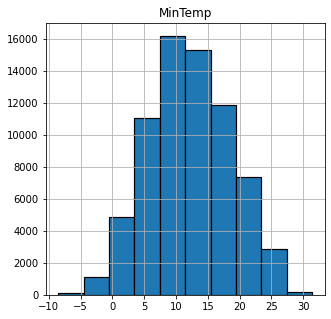

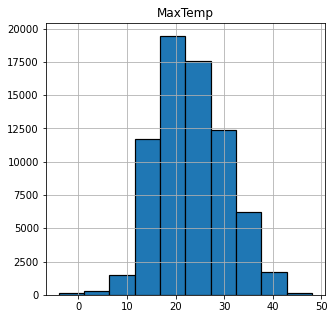

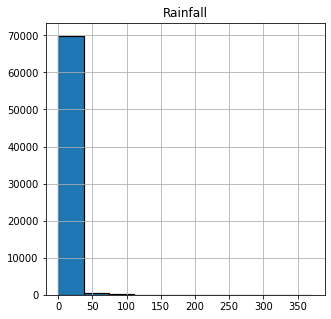

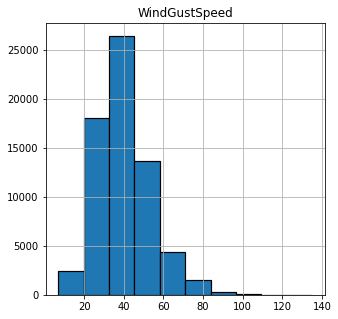

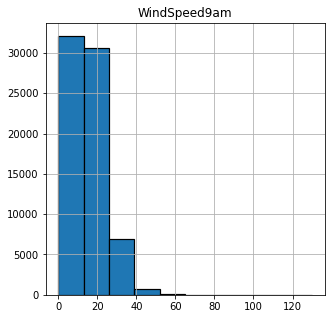

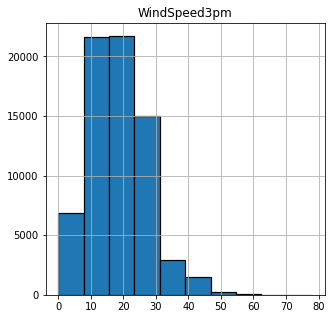

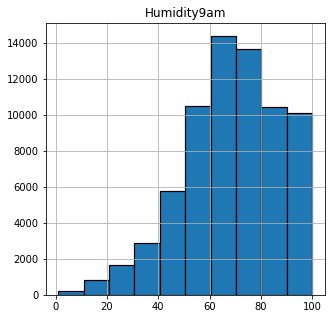

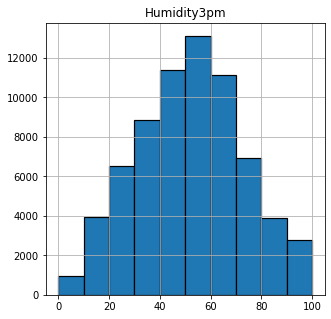

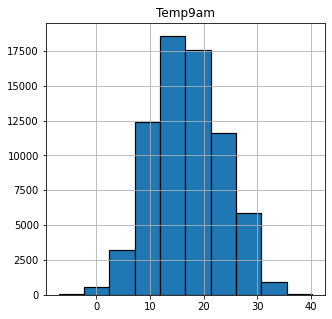

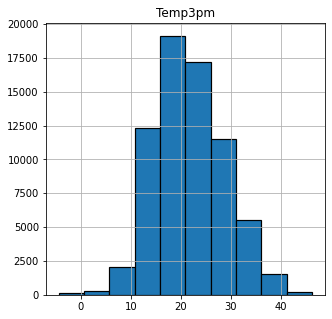

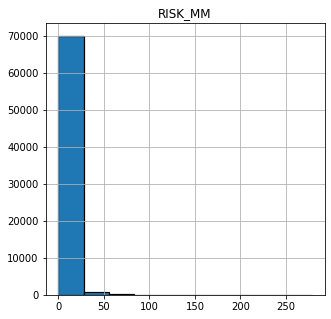

In [62]:
for column in float_cols:
  gre_histogram = df_sample.select(column).toPandas()
  gre_histogram.hist(edgecolor='black', column= column,
        linewidth=1.2, figsize=(5, 5))

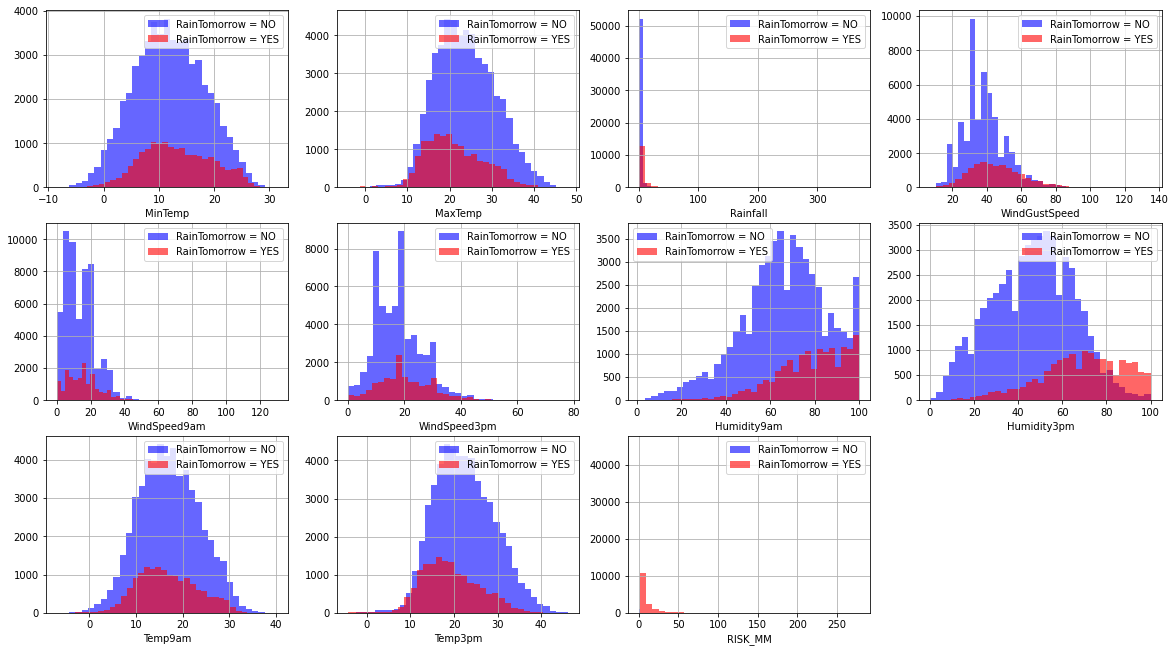

In [63]:
from pyspark.sql.functions import countDistinct
   
plt.figure(figsize=(20, 15))
df_sample = df_sample.toPandas()
for i,column in enumerate(float_cols,1):
  plt.subplot(4,4,i)
  df_sample[df_sample["RainTomorrow"] == "No"][column].hist(bins=35, color='blue', label='RainTomorrow = NO', alpha=0.6)
  df_sample[df_sample["RainTomorrow"] == "Yes"][column].hist(bins=35, color='red', label='RainTomorrow = YES', alpha=0.6)
  plt.legend()
  plt.xlabel(column)

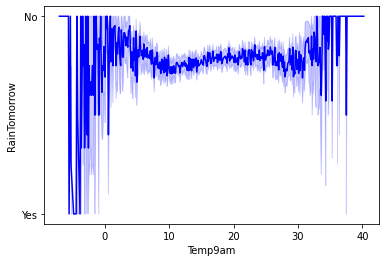

In [112]:
sns.lineplot(data=df_sample,x='Temp9am',y='RainTomorrow',color='blue')

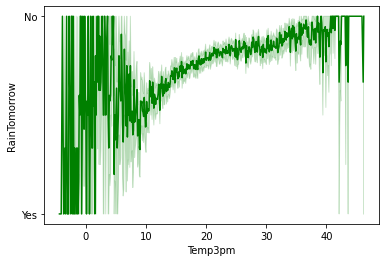

In [114]:
sns.lineplot(data=df_sample,x='Temp3pm',y='RainTomorrow',color='green')

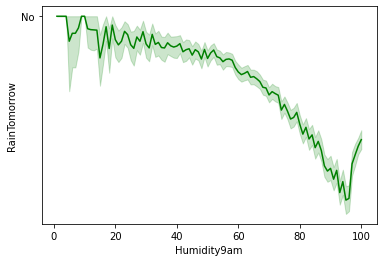

In [116]:
sns.lineplot(data=df_sample,x='Humidity9am',y='RainTomorrow',color='green')

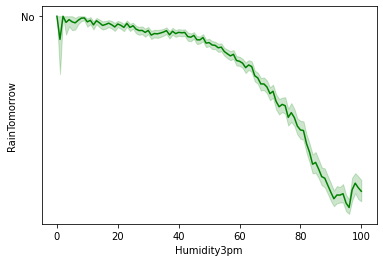

In [117]:
sns.lineplot(data=df_sample,x='Humidity3pm',y='RainTomorrow',color='green')

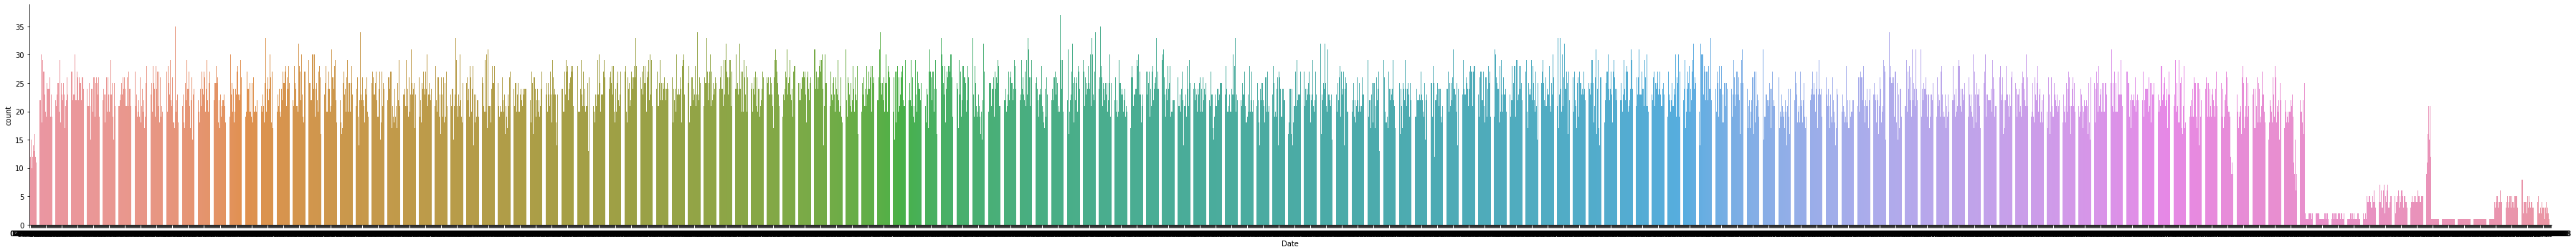

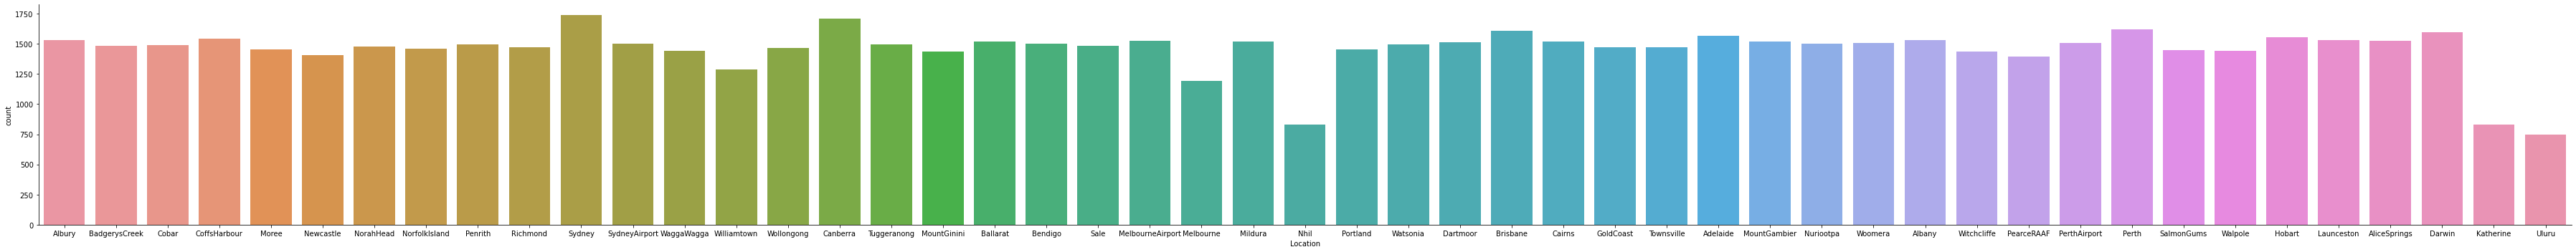

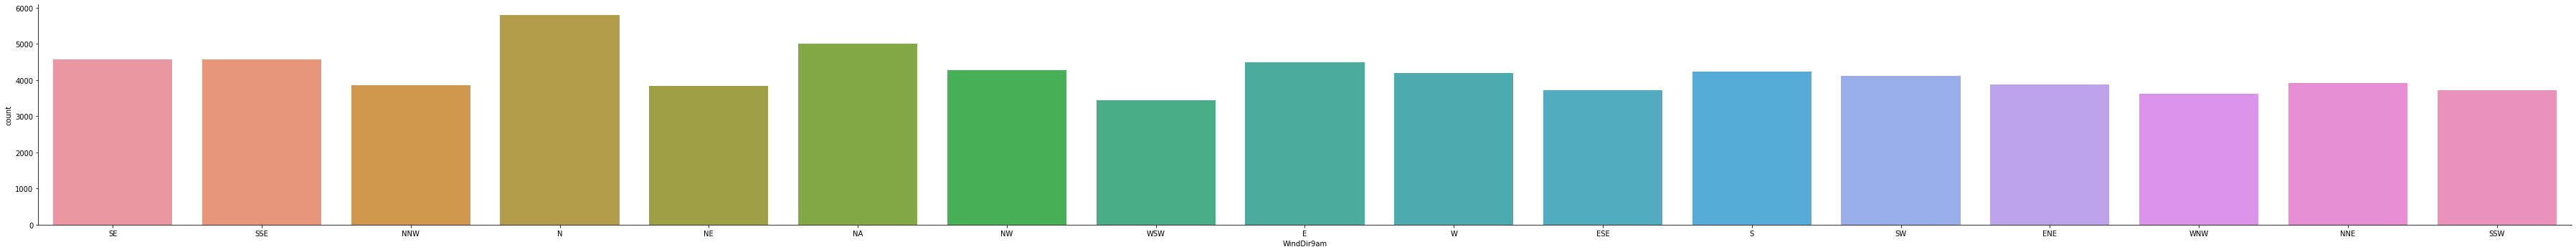

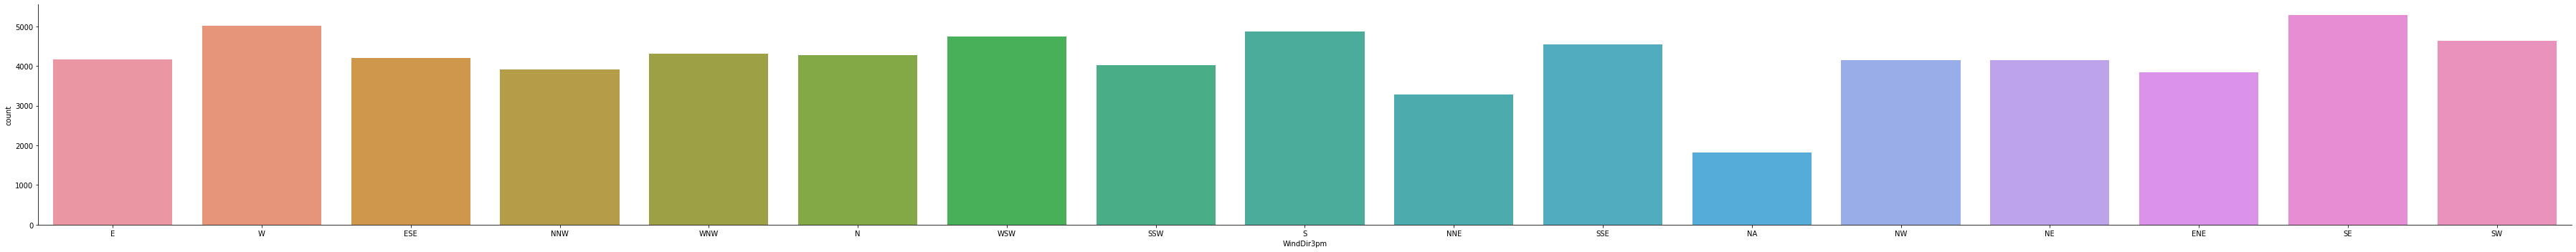

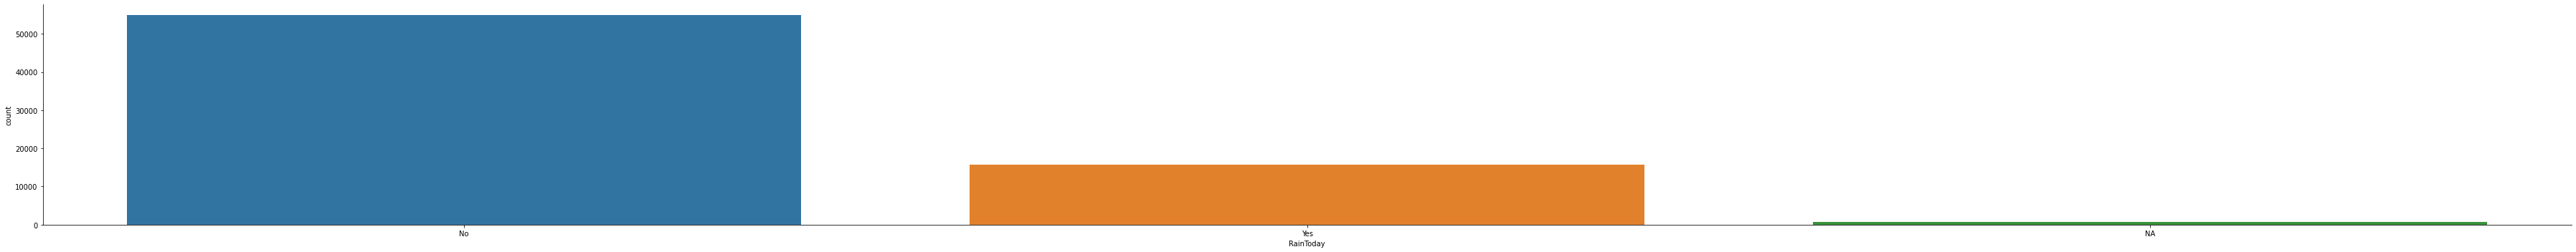

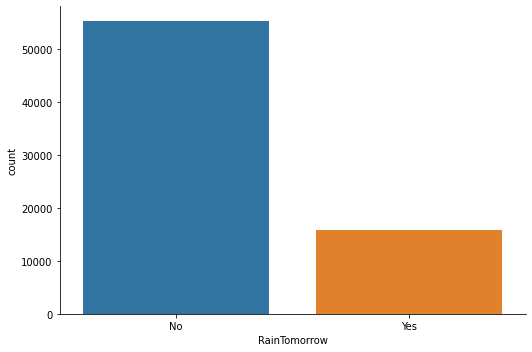

In [129]:
import seaborn as sb
cols=['Date', 'Location', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
# Function for plotting the categorical features
def plot_categorical(attr,labels=None):
    if(attr=='RainTomorrow'):
        sb.catplot(data=df_sample,kind='count',height=5,aspect=1.5,x=attr)
        return
    
    sb.catplot(data=df_sample,kind='count',height=5,aspect=3,x=attr)

for i in cols:
    plot_categorical(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


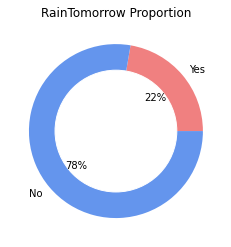

In [131]:
#RESULTS: Imbalanced data: 16% have left job, 84% have stayed

Y_count = len(df_sample[df_sample['RainTomorrow'] == 'Yes'])
N_count = len(df_sample[df_sample['RainTomorrow'] == 'No'])
# create data
names='Yes', 'No',
size=[Y_count,N_count]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("RainTomorrow Proportion")
plt.show()

In [64]:
#Running Query
df1 = spark.sql("SELECT * from temp").toPandas()
df2 = spark.sql("SELECT RainTomorrow, count(*) as cnt from temp group by RainTomorrow").toPandas()

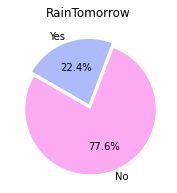

In [65]:
figure(figsize=(3,3))
myexplode = [0.08, 0]
mycolors = ["#fcabf3", "#adbbfa"]
fig = plt.pie(df2['cnt'], autopct='%1.1f%%', startangle=150,labels=df2['RainTomorrow'], explode = myexplode, colors=mycolors)
plt.title('RainTomorrow')
plt.show()

## Correlazioni

In [66]:
# funzione che calcola il Point biserial correlation coefficient, che e un coefficiente che ci permette di
# calcolare la correlazione di un attributo continuo rispetto a una variabile binaria
# per maggiori informazioni guarda qui:  https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient

def point_biserial_corr(df, attr, label):

  attr = df.select(attr).rdd.map(lambda x: x[0])
  label = df.select(label).rdd.map(lambda x: x[0])

  # creo la coppia (valore, label)
  data = attr.zip(label)
  # mappo la label in modo da ottenere dei valori binari
  data = data.map(lambda pair: (pair[0], int(0)) if pair[1] == 'No' else (pair[0], int(1)))
  # elimino i missing values
  data = data.filter(lambda x: (x[0] is not None) and (x[1] is not None)).filter(lambda x: (x[0] != 'NA') and (x[1] != 'NA'))
  # mappo l'attributo da studiare a float
  data = data.map(lambda pair: (float(pair[0]), pair[1]))

  attr= data.map(lambda pair: pair[0])

  # computo i dati che mi servono per calcolare la formula del point biserial correlation coefficient:
  m1 = data.filter(lambda pair: pair[1] == 1).map(lambda pair: pair[0]).mean()
  m0 = data.filter(lambda pair: pair[1] == 0).map(lambda pair: pair[0]).mean()
  std_dev= attr.stdev()
  n1= data.filter(lambda pair: pair[1] == 1).count()
  n0= data.filter(lambda pair: pair[1] == 0).count()
  n= attr.count()

  # computo il coefficiente 
  r = ((m1 - m0) / std_dev * sqrt( (n0 * n1) / n**2) )

  return r

In [67]:
def corr_to_target(df, cols):
  corrs_2_rain = dict()
  for col in cols:
    r= point_biserial_corr(df, str(col), 'RainTomorrow')
    corrs_2_rain[col] = r
  return corrs_2_rain

In [68]:
# get attribute most correlated with a threshold = 0.20, in this case
def get_most_corrs(corrs_dict, thr):
  for corrs in corrs_dict.items():
    if abs(corrs[1] )>= thr:
      print(corrs[0], ' : ', corrs[1])

In [69]:
def replace_NA(df, cols):
  for column in cols:
    df = df.withColumn(column,  when(col(column) == 'NA', regexp_replace(column, 'NA', '0')).otherwise(col(column)) )\
           .withColumn(column, col(column).cast(FloatType()))

    remove_cols= [col for col in df.columns if col not in cols]
    df = df.drop(*remove_cols)

  return df

In [70]:
def df_cast_float(df):
  for column in df.columns:
    df = df.withColumn(column, col(column).cast(FloatType()))

  return df

In [71]:
# questa funzione converte i valori NA in 0 e poi tutta la colonna in float, dopodiche calcola il pearson coefficient
def calc_str_corr(df, col1, col2):
  df2 = df.withColumn(col1,  when( col(col1) == 'NA', regexp_replace(col1, 'NA', '0') ).otherwise(col(col1)) )\
          .withColumn(col1, col(col1).cast(FloatType()))

  df2 = df2.withColumn(col2,  when(col(col2) == 'NA', regexp_replace(col2, 'NA', '0')).otherwise(col(col2)) )\
           .withColumn(col2, col(col2).cast(FloatType()))
    
  print(df2.corr(col1, col2))

In [72]:
# questa funzione permette di calcolare la correlation matrix
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)
  
    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

In [73]:
# Visualizziamo la heatmap
def plot_correlation(df_casted):
  plt.figure(figsize=(13, 10))
  heatmap = sns.heatmap(correlation_matrix(df_casted, df_casted.columns), vmin=-1, vmax=1, annot=True)
  heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#### Correlazioni: dataset originale con la variabile target RainTomorrow

In [74]:
no_cols= ['Date', 'Location', 'RainToday', 'RISK_MM', 'RainTomorrow', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

cols = [col for col in df.columns if col not in no_cols ]

corrs_2_rain = corr_to_target(df, cols)

corrs_2_rain

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [75]:
get_most_corrs(corrs_2_rain, 0.20)

Rainfall  :  0.23903180145061267
Sunshine  :  -0.4507680631061147
WindGustSpeed  :  0.2340097255174442
Humidity9am  :  0.25716116034379544
Humidity3pm  :  0.44616037879131
Pressure9am  :  -0.24637114625933842
Pressure3pm  :  -0.2260311455256092
Cloud9am  :  0.31737982970634687
Cloud3pm  :  0.3818704110470061


In [76]:
calc_str_corr(df, 'Sunshine', 'Cloud3pm')

0.08207235921989939


In [77]:
df_replaced= replace_NA(df, cols)
df_casted = df_cast_float(df_replaced)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


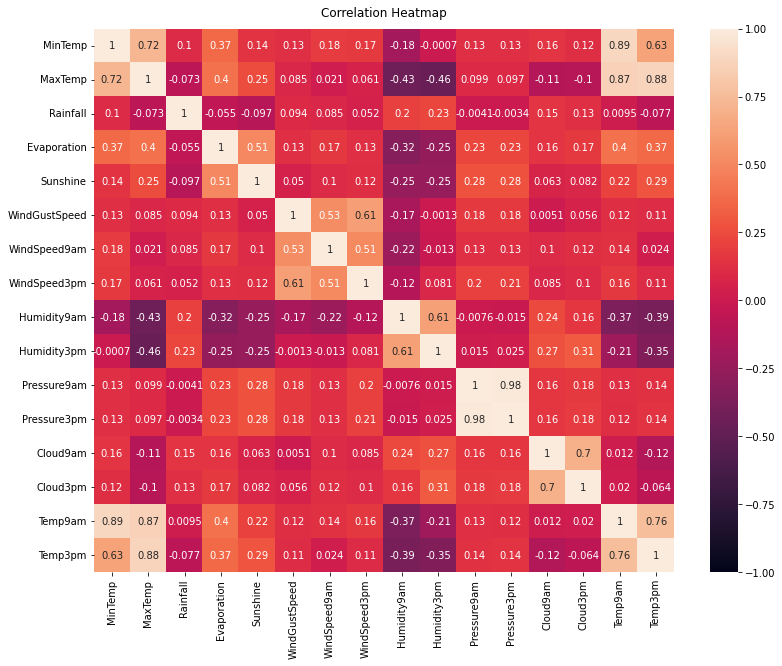

In [78]:
plot_correlation(df_casted)

#### Correlazioni: oggi non piove e domani sì

In [79]:
# colonna chiamata it-will-rain che assume valore 'Yes' se oggi non piove e domani piove e 'No' per tutti gli altri casi

df_will_rain = df.withColumn( 'it-will-rain' , when( (df.RainToday == 'No') & ( df.RainTomorrow == 'Yes'), 'Yes' ).otherwise('No') )

no_cols= ['Date', 'Location', 'RainToday', 'RISK_MM', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'it-will-rain']

cols = [col for col in df_will_rain.columns if col not in no_cols ]

corrs_2_rain2 = corr_to_target(df_will_rain, cols)

corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [80]:
corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [81]:
df_will_rain = df_will_rain.where(df_will_rain['it-will-rain'] == 'Yes')

In [82]:
get_most_corrs(corrs_2_rain2, 0.20)

Rainfall  :  0.23903180145061267
Sunshine  :  -0.4507680631061147
WindGustSpeed  :  0.2340097255174442
Humidity9am  :  0.25716116034379544
Humidity3pm  :  0.44616037879131
Pressure9am  :  -0.24637114625933842
Pressure3pm  :  -0.2260311455256092
Cloud9am  :  0.31737982970634687
Cloud3pm  :  0.3818704110470061


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


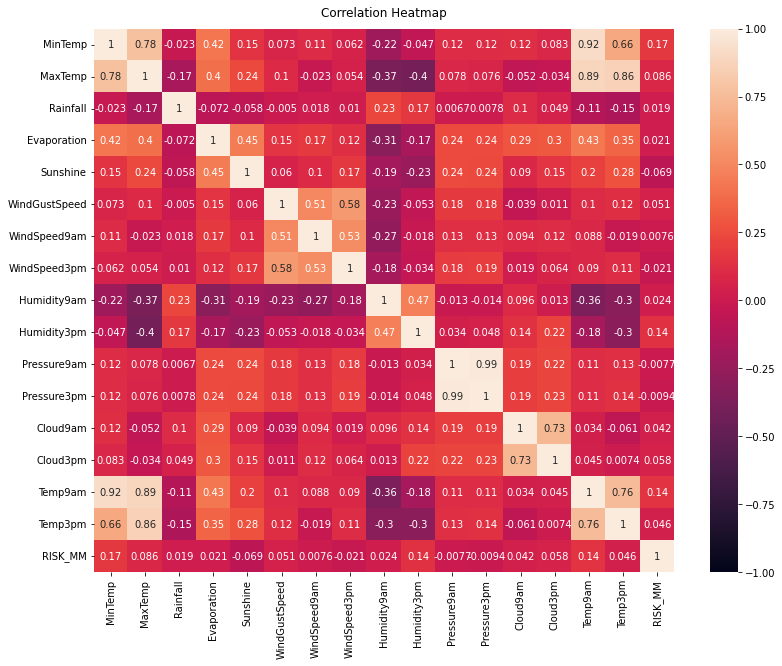

In [83]:
no_cols= ['Date', 'Location', 'RainToday', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'it-will-rain']

cols = [col for col in df_will_rain.columns if col not in no_cols ]

df_replaced = replace_NA(df_will_rain, cols)
df_casted = df_cast_float(df_replaced)

plot_correlation(df_casted)

#### Correlazioni: oggi piove e pioverà domani

In [84]:
# colonna chiamata it-rain che assume valore 'Yes' se oggi piove e domani piove e 'No' per tutti gli altri casi

df_it_rain = df.withColumn( 'it-rain' , when( (df.RainToday == 'Yes') & ( df.RainTomorrow == 'Yes'), 'Yes' ).otherwise('No') )

no_cols= ['Date', 'Location', 'RainToday', 'RISK_MM', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'it-rain']

cols = [col for col in df_it_rain.columns if col not in no_cols ]

corrs_2_rain2 = corr_to_target(df_it_rain, cols)

corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [85]:
corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [86]:
df_it_rain = df_it_rain.where(df_it_rain['it-rain'] == 'Yes')

In [87]:
get_most_corrs(corrs_2_rain2, 0.20)

Rainfall  :  0.23903180145061267
Sunshine  :  -0.4507680631061147
WindGustSpeed  :  0.2340097255174442
Humidity9am  :  0.25716116034379544
Humidity3pm  :  0.44616037879131
Pressure9am  :  -0.24637114625933842
Pressure3pm  :  -0.2260311455256092
Cloud9am  :  0.31737982970634687
Cloud3pm  :  0.3818704110470061


In [88]:
no_cols= ['Date', 'Location', 'RainToday', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'it-rain']

cols = [col for col in df_it_rain.columns if col not in no_cols ]

df_replaced = replace_NA(df_it_rain, cols)
df_casted = df_cast_float(df_replaced)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


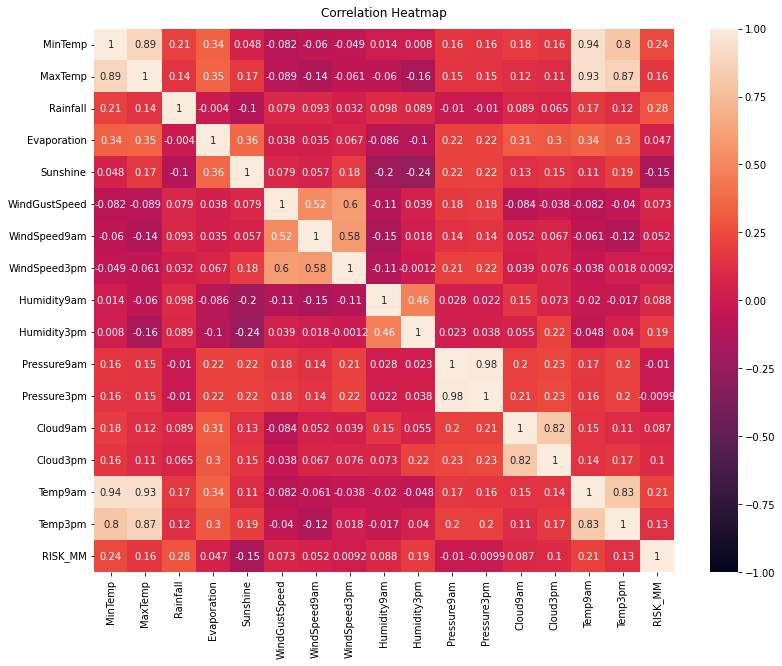

In [89]:
plot_correlation(df_casted)

#### Correlazioni: oggi non piove e nemmeno domani 

In [90]:
# colonna chiamata no-rain che assume valore 'Yes' se oggi non piove e domani non piove e 'No' per tutti gli altri casi

df_no_rain = df.withColumn( 'no-rain' , when( (df.RainToday == 'No') & ( df.RainTomorrow == 'No'), 'Yes' ).otherwise('No') )

no_cols= ['Date', 'Location', 'RainToday', 'RISK_MM', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'no-rain']

cols = [col for col in df_no_rain.columns if col not in no_cols ]

corrs_2_rain2 = corr_to_target(df_no_rain, cols)

In [91]:
corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [92]:
df_no_rain = df_no_rain.where(df_no_rain['no-rain'] == 'Yes')

In [93]:
get_most_corrs(corrs_2_rain2, 0.20)

Rainfall  :  0.23903180145061267
Sunshine  :  -0.4507680631061147
WindGustSpeed  :  0.2340097255174442
Humidity9am  :  0.25716116034379544
Humidity3pm  :  0.44616037879131
Pressure9am  :  -0.24637114625933842
Pressure3pm  :  -0.2260311455256092
Cloud9am  :  0.31737982970634687
Cloud3pm  :  0.3818704110470061


In [94]:
no_cols= ['Date', 'Location', 'RainToday', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'no-rain']

cols = [col for col in df_no_rain.columns if col not in no_cols ]

df_replaced = replace_NA(df_no_rain, cols)
df_casted = df_cast_float(df_replaced)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


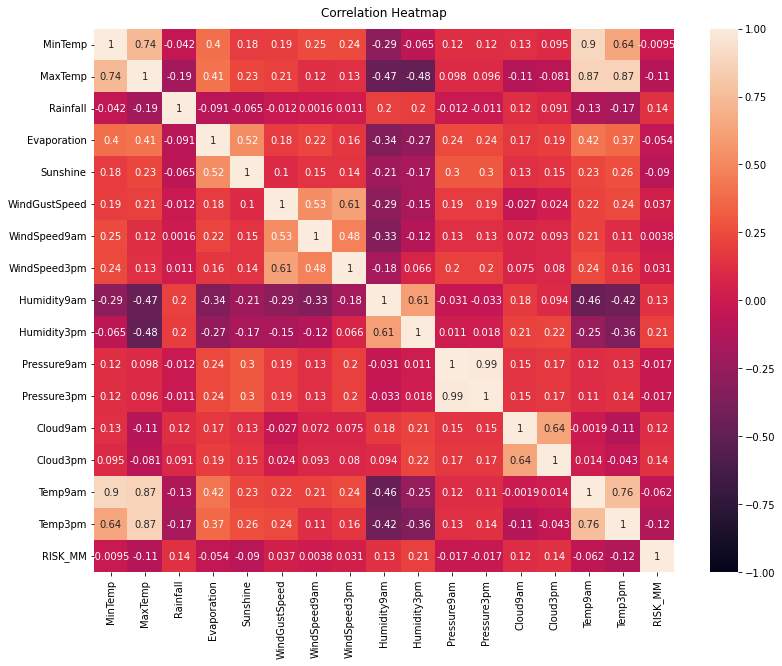

In [95]:
plot_correlation(df_casted)

#### Correlazioni: oggi piove e domani non pioverà

In [96]:
# colonna chiamata end-rain che assume valore 'Yes' se oggi piove e domani non piove e 'No' per tutti gli altri casi

df_end_rain = df.withColumn( 'end-rain' , when( (df.RainToday == 'Yes') & ( df.RainTomorrow == 'No'), 'Yes' ).otherwise('No') )

no_cols= ['Date', 'Location', 'RainToday', 'RISK_MM', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'end-rain']

cols = [col for col in df_end_rain.columns if col not in no_cols ]

corrs_2_rain2 = corr_to_target(df_end_rain, cols)

corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [97]:
corrs_2_rain2

{'Cloud3pm': 0.3818704110470061,
 'Cloud9am': 0.31737982970634687,
 'Evaporation': -0.11928469674514104,
 'Humidity3pm': 0.44616037879131,
 'Humidity9am': 0.25716116034379544,
 'MaxTemp': -0.15923666414933282,
 'MinTemp': 0.0839358135015659,
 'Pressure3pm': -0.2260311455256092,
 'Pressure9am': -0.24637114625933842,
 'Rainfall': 0.23903180145061267,
 'Sunshine': -0.4507680631061147,
 'Temp3pm': -0.1924240867011652,
 'Temp9am': -0.025690822604571943,
 'WindGustSpeed': 0.2340097255174442,
 'WindSpeed3pm': 0.08781739865079892,
 'WindSpeed9am': 0.09099465016311015}

In [98]:
df_end_rain = df_end_rain.where(df_end_rain['end-rain'] == 'Yes')

In [99]:
get_most_corrs(corrs_2_rain2, 0.20)

Rainfall  :  0.23903180145061267
Sunshine  :  -0.4507680631061147
WindGustSpeed  :  0.2340097255174442
Humidity9am  :  0.25716116034379544
Humidity3pm  :  0.44616037879131
Pressure9am  :  -0.24637114625933842
Pressure3pm  :  -0.2260311455256092
Cloud9am  :  0.31737982970634687
Cloud3pm  :  0.3818704110470061


In [100]:
no_cols= ['Date', 'Location', 'RainToday', 'RainTomorrow', 
          'WindGustDir', 'WindDir9am', 'WindDir3pm', 'end-rain']

cols = [col for col in df_end_rain.columns if col not in no_cols ]

df_replaced = replace_NA(df_end_rain, cols)
df_casted = df_cast_float(df_replaced)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


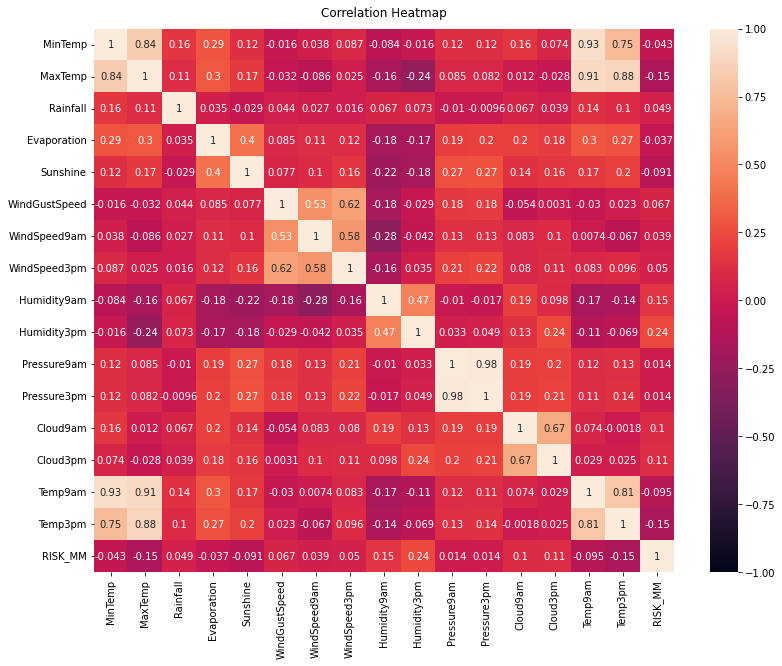

In [101]:
plot_correlation(df_casted)

## Analisi missing values

In [102]:
# Sostituisco 'NA' con null values
df = df.replace('NA', None)
df.show(5) 

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|01/12/2008|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|    null|   16.9|   21.8|       No|  

In [103]:
# Creazione dataset con osservazioni contenenti solo null values
df_null = df.filter(F.greatest(*[F.col(i).isNull() for i in df.columns]))
df_null.show(5)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|01/12/2008|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|    null|   16.9|   21.8|       No|  

In [104]:
# Colonne con più null values
print('Totale osservazioni: 142193')
print()

Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null = sorted(Dict_Null.items(), key=lambda x: x[1], reverse=True)

for i in Dict_Null:
	print(i[0], i[1])

Totale osservazioni: 142193

Sunshine 67816
Evaporation 60843
Cloud3pm 57094
Cloud9am 53657
Pressure9am 14014
Pressure3pm 13981
WindDir9am 10013
WindGustDir 9330
WindGustSpeed 9270
WindDir3pm 3778
Humidity3pm 3610
Temp3pm 2726
WindSpeed3pm 2630
Humidity9am 1774
Rainfall 1406
RainToday 1406
WindSpeed9am 1348
Temp9am 904
MinTemp 637
MaxTemp 322
Date 0
Location 0
RISK_MM 0
RainTomorrow 0


In [105]:
# Analisi dei null values sulle colonne con più valori mancanti, raggruppati per città

from pyspark.ml.stat import Correlation

cols = ["Evaporation", "Sunshine", "Cloud3pm", "Cloud9am"]

for c in cols:
    x = df.filter(df[c].isNull()).groupby(df.Location).count()

    print('Null values for column {}'.format(c),'(grouped by city)')
    x.sort("count", ascending=False).show(10)  # con print dà un None di troppo

Null values for column Evaporation (grouped by city)
+-----------+-----+
|   Location|count|
+-----------+-----+
|   Ballarat| 3028|
|     Albury| 3011|
|Tuggeranong| 2998|
| Wollongong| 2983|
|  GoldCoast| 2980|
|    Penrith| 2964|
| SalmonGums| 2955|
|  Newcastle| 2955|
|Witchcliffe| 2952|
|  NorahHead| 2929|
+-----------+-----+
only showing top 10 rows

Null values for column Sunshine (grouped by city)
+-----------+-----+
|   Location|count|
+-----------+-----+
|    Bendigo| 3034|
| Launceston| 3028|
|   Ballarat| 3028|
|     Albury| 3011|
|Tuggeranong| 2998|
| Wollongong| 2983|
|  GoldCoast| 2980|
|    Penrith| 2964|
|  Newcastle| 2955|
| SalmonGums| 2955|
+-----------+-----+
only showing top 10 rows

Null values for column Cloud3pm (grouped by city)
+-------------+-----+
|     Location|count|
+-------------+-----+
|     Adelaide| 3090|
|  Tuggeranong| 2998|
|    GoldCoast| 2980|
|      Penrith| 2964|
|   SalmonGums| 2955|
|  Witchcliffe| 2952|
|     Dartmoor| 2943|
|    NorahHead|

In [106]:
# Analisi dei null values sulle colonne con più valori mancanti, raggruppati per RainTomorrow

cols = ["Evaporation", "Sunshine", "Cloud3pm", "Cloud9am"]

for c in cols:
    x = df.filter(df[c].isNull()).groupby(df.RainTomorrow).count()

    print('Null values for column {}'.format(c),'(grouped by RainTomorrow)')
    x.sort("count", ascending=False).show(10)  

Null values for column Evaporation (grouped by RainTomorrow)
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|          No|46825|
|         Yes|14018|
+------------+-----+

Null values for column Sunshine (grouped by RainTomorrow)
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|          No|52760|
|         Yes|15056|
+------------+-----+

Null values for column Cloud3pm (grouped by RainTomorrow)
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|          No|45505|
|         Yes|11589|
+------------+-----+

Null values for column Cloud9am (grouped by RainTomorrow)
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|          No|42402|
|         Yes|11255|
+------------+-----+



In [107]:
# Analisi dei null values sulle colonne con più valori mancanti, raggruppati per RainToday
# L'attributo RainToday, a differenza dei precedenti, presenta null values

cols = ["Evaporation", "Sunshine", "Cloud3pm", "Cloud9am"]

for c in cols:
    x = df.filter(df[c].isNull()).groupby(df.RainToday).count()

    print('Null values for column {}'.format(c),'(grouped by RainToday)')
    x.sort("count", ascending=False).show(10)

Null values for column Evaporation (grouped by RainToday)
+---------+-----+
|RainToday|count|
+---------+-----+
|       No|46035|
|      Yes|13659|
|     null| 1149|
+---------+-----+

Null values for column Sunshine (grouped by RainToday)
+---------+-----+
|RainToday|count|
+---------+-----+
|       No|52046|
|      Yes|14759|
|     null| 1011|
+---------+-----+

Null values for column Cloud3pm (grouped by RainToday)
+---------+-----+
|RainToday|count|
+---------+-----+
|       No|44717|
|      Yes|11377|
|     null| 1000|
+---------+-----+

Null values for column Cloud9am (grouped by RainToday)
+---------+-----+
|RainToday|count|
+---------+-----+
|       No|42010|
|      Yes|10615|
|     null| 1032|
+---------+-----+



In [108]:
pandas_df = df.toPandas()

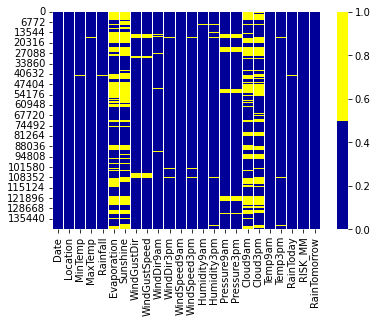

In [132]:
#Visualize the missing data patterns
cols = pandas_df.columns[:30] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sb.heatmap(pandas_df[cols].isnull(), cmap=sb.color_palette(colours))

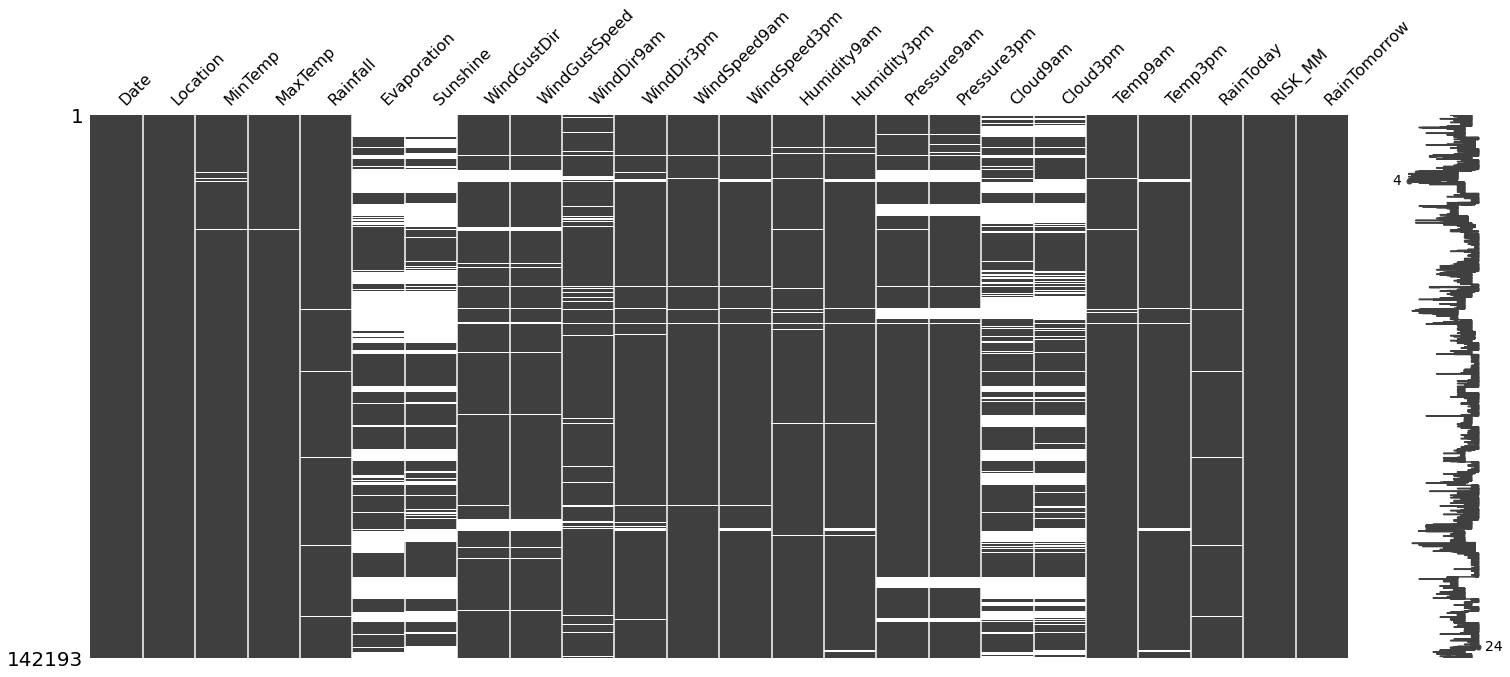

In [109]:
msno.matrix(pandas_df)

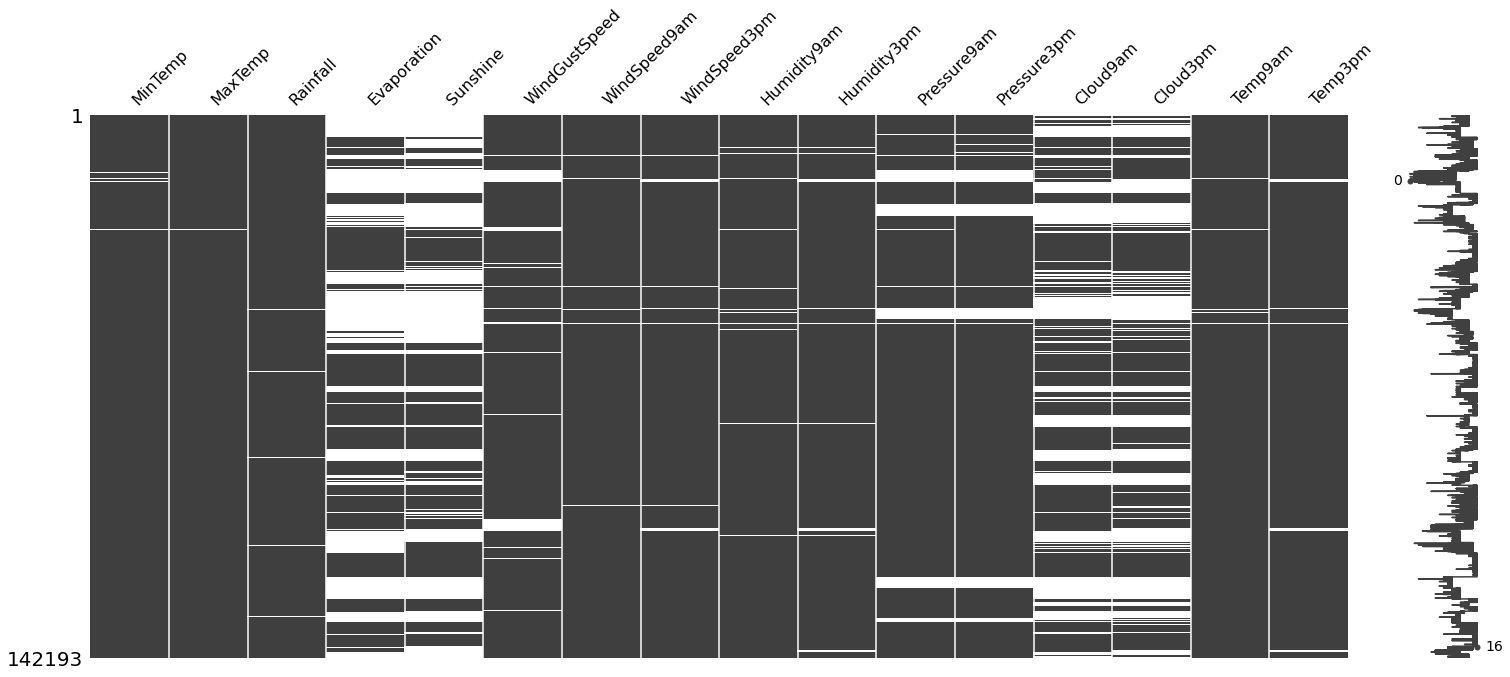

In [110]:
msno.matrix(pandas_df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']])

correlazione di nullità: cioè quanto fortemente la presenza o l'assenza di una variabile influisce sulla presenza di un'altra.

La correlazione di nullità varia da:



*  -1(se una variabile appare, l'altra sicuramente no)
*   a 0 (le variabili che appaiono o non appaiono non hanno alcun effetto l'una sull'altra)
*  a 1(se una variabile appare anche l'altra lo fa sicuramente).

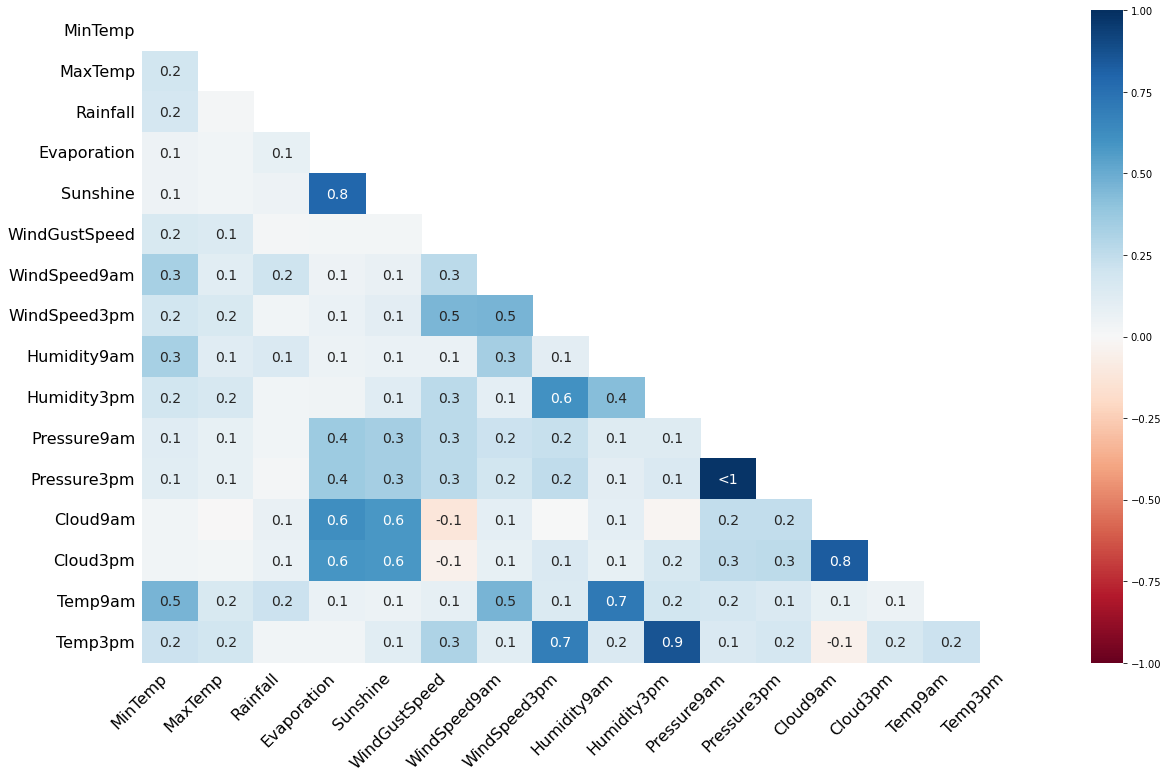

In [111]:
msno.heatmap(pandas_df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']])

Possiamo vedere che le maggiori correlazioni di missing values sono tra le variabili rilevate alle 3 del pomeriggio e alle 9 del mattino. Ma abbiamo anche Humidity 3pm fortemente correlata a Temp3pm.

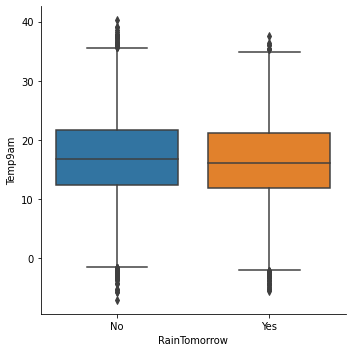

In [137]:
sb.catplot(data=df_sample,y='Temp9am',x='RainTomorrow',height=5,aspect=1,kind='box')